In [48]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [49]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"../backend/top_indian_donors{year}_withprofiles_reconvert.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
cmtes_csv = f"./data/CampaignFin{year}/cmtes{year}.txt"

In [50]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,...,med_donation,sector,ethnic,indian,gpt_profile,primary_party,d_ratio,r_ratio,other_ratio,tag
0,,ACTBLUE,Actblue Actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,...,1000.0,Unknown,not,False,NaN,D,0.480966,0.389946,0.129088,Bipartisan
1,U00000037041,"BLOOMBERG, MICHAEL R",Michael R Bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,...,682.5,Party,not,False,NaN,D,0.999715,0.000000,0.000285,Solidly Democrat
2,U00000036521,"STEYER, TOM",Tom Steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,...,2800.0,Party,not,False,NaN,D,0.992717,0.000000,0.007283,Solidly Democrat
3,U00000046841,"MELLON, TIMOTHY",Timothy Mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,...,2800.0,Finance,not,False,NaN,R,0.000111,0.999889,0.000000,Solidly Republican
4,U0000000310A,"ADELSON, MIRIAM",Miriam Adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,...,2800.0,Health,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
5,U00000003101,"ADELSON, SHELDON G",Sheldon G Adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,...,2800.0,NaN,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
6,U00000036901,"UIHLEIN, RICHARD",Richard Uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,...,2800.0,Manufacturing,not,False,NaN,R,0.000000,0.862281,0.137719,Solidly Republican
7,U00000036551,"GRIFFIN, KENNETH",Kenneth Griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,...,2800.0,Finance,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican
8,U00000003611,"SCHWARZMAN, STEPHEN A",Stephen A Schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,...,2800.0,Finance,not,False,NaN,R,0.000094,0.999906,0.000000,Solidly Republican
9,U00000046781,"JURVETSON, KARLA",Karla Jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,...,2800.0,Health,not,False,NaN,D,0.984513,0.000000,0.015487,Solidly Democrat


In [51]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [52]:
lf = (
        pl.scan_csv(
            cmtes_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'cmte_id', 'pac_short', 'affiliate', 'pac', 
                        'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code', 
                        'source', 'sensitive', 'foreign', 'active'],
            ignore_errors=True
        )
        .select(['cmte_id', 'pac_short', 'affiliate', 'pac',
                 'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code',
                 'source', 'sensitive', 'foreign', 'active'])
    )
cmtes = lf.collect(streaming=True)
cmtes = cmtes.to_pandas()
cmtes[cmtes["party"] == "L"]

,cmte_id,pac_short,affiliate,pac,recip_id,recipcode,cand_id,party,prim_code,source,sensitive,foreign,active
1426,C00255695,Libertarian National Cmte,Libertarian Party,Libertarian Party,C00255695,3P,None,L,Z5300,Rept,n,0,1
1745,C00315713,Libertarian Party of Illinois,Libertarian Party,Libertarian Party,C00315713,3P,None,L,Z5300,Rept,N,0,1
1878,C00332221,Libertarian Assn of Massachusetts,Libertarian Party,Libertarian Party,C00332221,3P,None,L,Z5300,Rept,N,0,1
2649,C00399865,Libertarian Party of Virginia,Libertarian Party,Libertarian Party,C00399865,3P,None,L,Z5300,Rept,N,0,1
2658,C00400945,Libertarian Party of South Carolina,Libertarian Party,Libertarian Party,C00400945,3P,None,L,Z5300,Rept,n,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16745,C00758250,Liz Terwilliger for Congress,None,Liz Terwilliger for Congress,N00047569,3L,H0PA12207,L,Z1300,Rept,N,0,1
16861,C00759423,COMMITTEE TO ELECT TWHAMBY ...,None,None,C00759423,None,None,L,None,None,None,0,0
17029,C00761130,PRESTON NELSON FOR CONGRESS ...,None,None,N00042426,3L,H0IL08165,L,None,None,N,0,0
17181,C00762732,ITSBEAUTIME ...,None,None,N00047809,3N,P40004277,L,None,None,N,0,0


In [53]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    2123
Finance                  2112
Law                       621
Tech                      573
Ideology/Single Issue     534
Health                    523
Unknown                   428
Construction              283
Energy                    272
Manufacturing             244
Transportation            236
Agribusiness              137
Defense                    30
Labor                       2
Name: count, dtype: int64

In [54]:
# preds = pd.read_csv(pred_csv)
# donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
# donors = donors.merge(cands, on='recip_id', how='left')

In [55]:
'''contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors'''

"contrib_party_totals = (\n    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']\n    .sum()\n    .unstack()\n    .fillna(0)\n)\n\ncontrib_party_totals['dem_ratio'] = (\n    contrib_party_totals.get('D', 0) / \n    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))\n)\n\ndonors = donors.merge(\n    contrib_party_totals['dem_ratio'].reset_index(),\n    on=['contrib_id', 'name_new'],\n    how='left'\n)\n\ndonors"

In [56]:
'''donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()'''

'donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")\ndonors["level"].value_counts()'

In [57]:
def read_and_process_donors_csv(year):
    
    # define files
    pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
    donors_csv = f"../backend/top_indian_donors{year}_withprofiles_reconvert.csv"
    cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
    
    # read donors csv
    donors = pd.read_csv(donors_csv)
    
    # read cands csv
    cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

    # cands = cands_lf.collect()
    # cands = cands.to_pandas()
    # cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
    
    # map sectors
    donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
    
    # merge the three csvs
    '''preds = pd.read_csv(pred_csv)
    donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
    donors = donors.merge(cands, on='recip_id', how='left')
    
    # calculate dem ratio
    contrib_party_totals = (
        donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
        .sum()
        .unstack()
        .fillna(0)
    )

    contrib_party_totals['dem_ratio'] = (
        contrib_party_totals.get('D', 0) / 
        (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
    )

    donors = donors.merge(
        contrib_party_totals['dem_ratio'].reset_index(),
        on=['contrib_id', 'name_new'],
        how='left'
    )
    
    # map levels
    donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else 
                                           "President" if str(x) == "PRES" else 
                                           "House" if type(x) == str and len(str(x)) == 4 else 
                                           "Unknown")'''
    
    # add electoral cycle    
    donors["cycle"] = f"20{year}"

    return donors

In [58]:
all_donors = donors
all_donors["cycle"] = f"20{year}"

for year in tqdm(list(filter(lambda x: x != year, ["00", "02", "04", "06", "08", 10, 12, 14, 16, 18, 20, 22]))):
    
    donors = read_and_process_donors_csv(year)
    all_donors = pd.concat([all_donors, donors], ignore_index=True)
    
all_donors["cycle"].value_counts()

100%|██████████| 11/11 [00:00<00:00, 11.39it/s]


cycle
2020    10000
2000    10000
2002    10000
2004    10000
2006    10000
2008    10000
2010    10000
2012    10000
2014    10000
2016    10000
2018    10000
2022    10000
Name: count, dtype: int64

In [59]:
all_donors

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,...,sector,ethnic,indian,gpt_profile,primary_party,d_ratio,r_ratio,other_ratio,tag,cycle
0,,ACTBLUE,Actblue Actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,...,Unknown,not,False,NaN,D,0.480966,0.389946,0.129088,Bipartisan,2020
1,U00000037041,"BLOOMBERG, MICHAEL R",Michael R Bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,...,Party,not,False,NaN,D,0.999715,0.000000,0.000285,Solidly Democrat,2020
2,U00000036521,"STEYER, TOM",Tom Steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,...,Party,not,False,NaN,D,0.992717,0.000000,0.007283,Solidly Democrat,2020
3,U00000046841,"MELLON, TIMOTHY",Timothy Mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,...,Finance,not,False,NaN,R,0.000111,0.999889,0.000000,Solidly Republican,2020
4,U0000000310A,"ADELSON, MIRIAM",Miriam Adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,...,Health,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,m00017184741,"MELVILLE, CAMERON",Cameron Melville,Club Helsinki Hudson,NaN,Y4000,M,MANAGMENT,CLUB HELSINKI HUDSON,HILLSDALE,...,Unknown,not,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2022
119996,h1011193584,"WILLIAMS, MICHAEL HOWARD MR",Michael Howard Mr Williams,[Candidate Contribution],NaN,Z9000,M,RETIRED,RETIRED,GEORGETOWN,...,Party,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2022
119997,h3001370526,"TOMLIN, LILY",Lily Tomlin,[24T Contribution],NaN,Z9500,F,ACTOR,SELF,ENCINO,...,Party,not,False,NaN,D,0.826287,0.000000,0.173713,Solidly Democrat,2022
119998,j1002609141,"GERHARDT, CHIP",Chip Gerhardt,Government Strategies Group,NaN,K2000,M,CONSULTANT,GOVERNMENT STRATEGIES GROUP,CINCINNATI,...,Law,not,False,NaN,R,0.000000,1.000000,0.000000,Only Republican,2022


In [60]:
agg_all = all_donors.groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_all['group'] = 'All Donors'
agg_indian = all_donors[all_donors['ethnic'] == 'ind'].groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_indian['group'] = 'Indian-American Donors'

combined = pd.concat([agg_all, agg_indian])

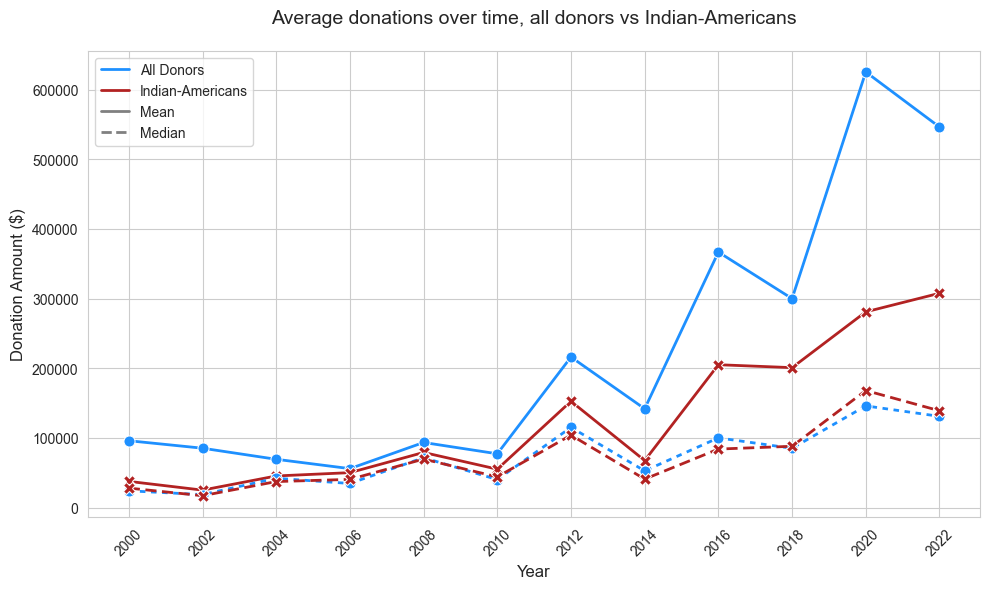

In [61]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined, x='cycle', y='mean', hue='group',
    style='group', markers=True, dashes=False,
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='o', markersize=8
)
sns.lineplot(
    data=combined, x='cycle', y='median', hue='group',
    style='group', markers=True, dashes=[(2,2), (4,2)],
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='s', markersize=8,
    legend=False
)

plt.title('Average donations over time, all donors vs Indian-Americans', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Donation Amount ($)', fontsize=12)
plt.xticks(rotation=45)

legend_elements = [
    Line2D([0], [0], color='dodgerblue', lw=2, label='All Donors'),
    Line2D([0], [0], color='firebrick', lw=2, label='Indian-Americans'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Mean'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Median')
]
plt.legend(handles=legend_elements, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

In [62]:
sector_counts_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_counts_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_pct_all = sector_counts_all.div(sector_counts_all.sum(axis=1), axis=0) * 100
sector_pct_indian = sector_counts_indian.div(sector_counts_indian.sum(axis=1), axis=0) * 100

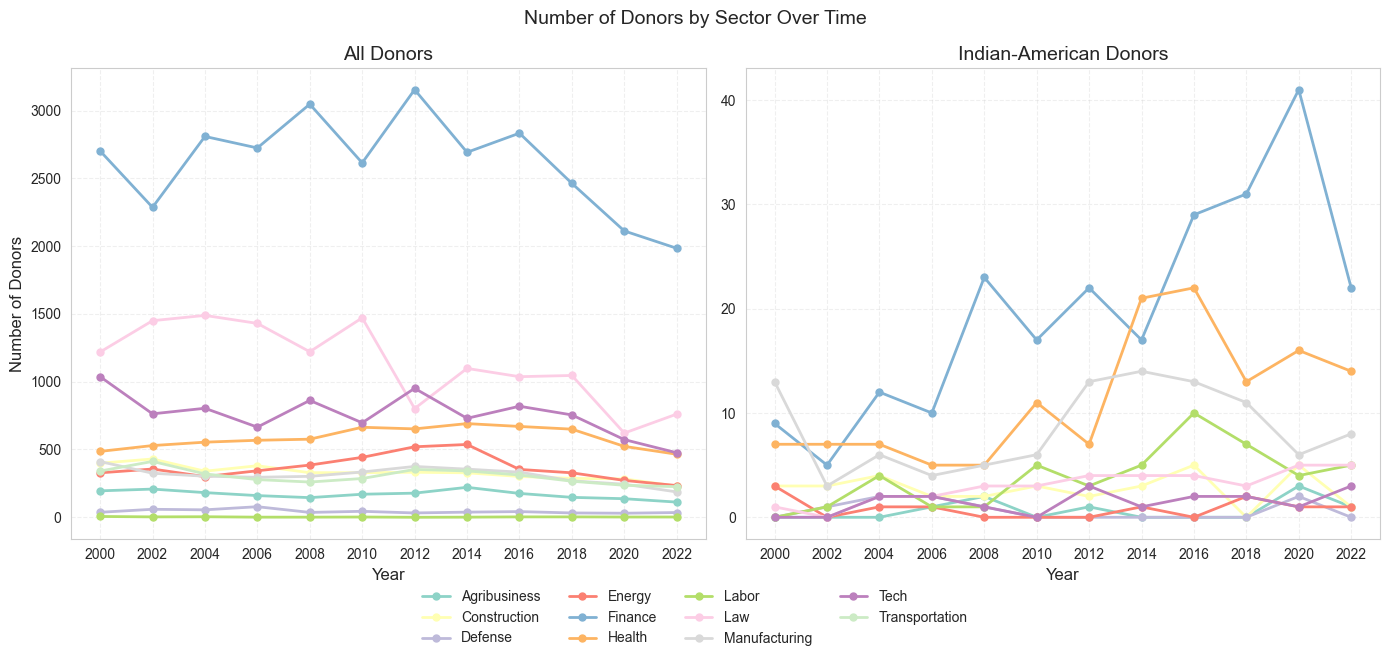

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
colors = sns.color_palette("Set3", n_colors=len(sector_counts_all.columns))

for i, sector in enumerate(sector_counts_all.columns):
    ax1.plot(
        sector_counts_all.index,
        sector_counts_all[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax1.set_title("All Donors", fontsize=14)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

for i, sector in enumerate(sector_counts_indian.columns):
    ax2.plot(
        sector_counts_indian.index,
        sector_counts_indian[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax2.set_title("Indian-American Donors", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=10,
    frameon=False
)

plt.suptitle("Number of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [64]:
sector_counts_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,195,399,37,328,2702,486,6,1219,411,1037,341
2002,208,430,59,356,2286,529,3,1450,325,763,412
2004,182,340,55,300,2809,554,4,1489,303,804,320
2006,160,380,78,343,2724,568,1,1430,295,665,278
2008,145,329,36,385,3047,576,1,1221,302,862,260
2010,170,329,44,442,2614,664,2,1471,334,697,286
2012,178,332,32,520,3154,652,0,802,375,951,353
2014,221,328,38,537,2692,691,1,1098,355,730,342
2016,176,301,42,353,2833,670,3,1037,333,819,312


In [65]:
sector_counts_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,
2000,0,3,0,3,9,7,0,1,13,0
2002,0,3,1,0,5,7,1,0,3,0
2004,0,4,2,1,12,7,4,2,6,2
2006,1,2,2,1,10,5,1,2,4,2
2008,2,2,1,0,23,5,1,3,5,1
2010,0,3,0,0,17,11,5,3,6,0
2012,1,2,0,0,22,7,3,4,13,3
2014,0,3,0,1,17,21,5,4,14,1
2016,0,5,0,0,29,22,10,4,13,2


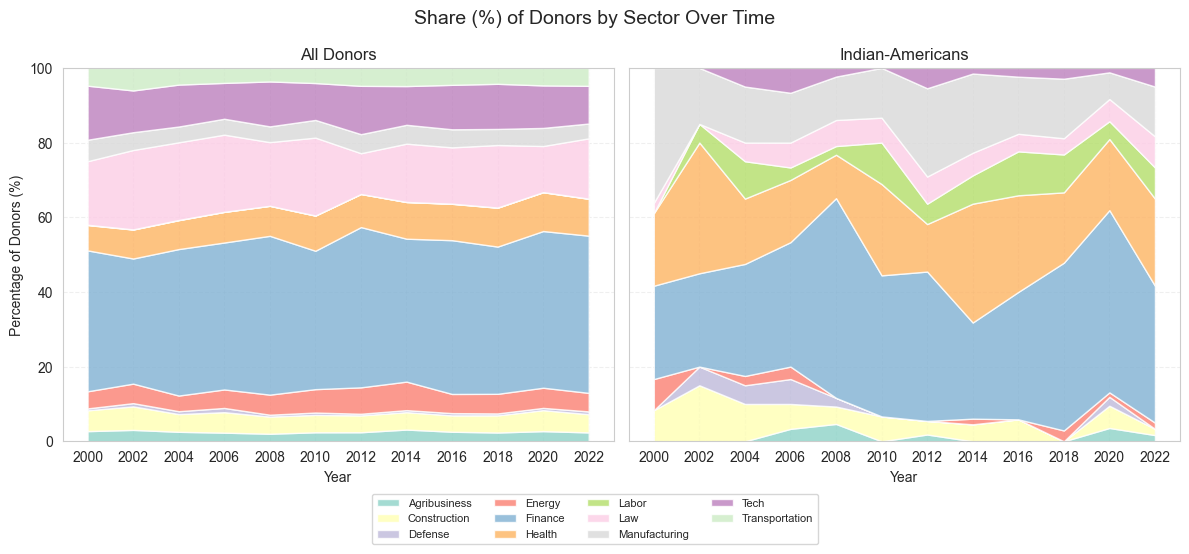

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all.columns))

ax1.stackplot(
    sector_pct_all.index,
    sector_pct_all.T,
    labels=sector_pct_all.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian.index,
    sector_pct_indian.T,
    labels=sector_pct_indian.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [67]:
sector_pct_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,2.723083,5.571848,0.516688,4.580366,37.732160,6.786762,0.083787,17.022762,5.739422,14.481218,4.761905
2002,3.049406,6.304061,0.864976,5.219176,33.514147,7.755461,0.043982,21.257880,4.764697,11.186043,6.040170
2004,2.541899,4.748603,0.768156,4.189944,39.231844,7.737430,0.055866,20.796089,4.231844,11.229050,4.469274
2006,2.311471,5.489743,1.126842,4.955215,39.352788,8.205721,0.014447,20.658769,4.261774,9.607050,4.016180
2008,2.024009,4.592406,0.502513,5.374093,42.532105,8.040201,0.013959,17.043551,4.215522,12.032384,3.629257
2010,2.410322,4.664682,0.623848,6.266837,37.062243,9.414434,0.028357,20.856373,4.735574,9.882320,4.055012
2012,2.422098,4.517621,0.435433,7.075793,42.917404,8.871955,0.000000,10.913049,5.102735,12.940536,4.803375
2014,3.142329,4.663728,0.540310,7.635433,38.276696,9.825110,0.014219,15.612114,5.047633,10.379639,4.862790
2016,2.558511,4.375636,0.610554,5.131560,41.183312,9.739788,0.043611,15.074866,4.840820,11.905800,4.535543


In [68]:
sector_pct_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,
2000,0.000000,8.333333,0.000000,8.333333,25.000000,19.444444,0.000000,2.777778,36.111111,0.000000
2002,0.000000,15.000000,5.000000,0.000000,25.000000,35.000000,5.000000,0.000000,15.000000,0.000000
2004,0.000000,10.000000,5.000000,2.500000,30.000000,17.500000,10.000000,5.000000,15.000000,5.000000
2006,3.333333,6.666667,6.666667,3.333333,33.333333,16.666667,3.333333,6.666667,13.333333,6.666667
2008,4.651163,4.651163,2.325581,0.000000,53.488372,11.627907,2.325581,6.976744,11.627907,2.325581
2010,0.000000,6.666667,0.000000,0.000000,37.777778,24.444444,11.111111,6.666667,13.333333,0.000000
2012,1.818182,3.636364,0.000000,0.000000,40.000000,12.727273,5.454545,7.272727,23.636364,5.454545
2014,0.000000,4.545455,0.000000,1.515152,25.757576,31.818182,7.575758,6.060606,21.212121,1.515152
2016,0.000000,5.882353,0.000000,0.000000,34.117647,25.882353,11.764706,4.705882,15.294118,2.352941


In [69]:
mean_all = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle", "sector"])["d_ratio"].mean().sort_values(ascending=False)
mean_ind = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle", "sector"])["d_ratio"].mean().sort_values(ascending=False)
mean_all = mean_all.unstack(level='sector')
mean_ind = mean_ind.unstack(level='sector')

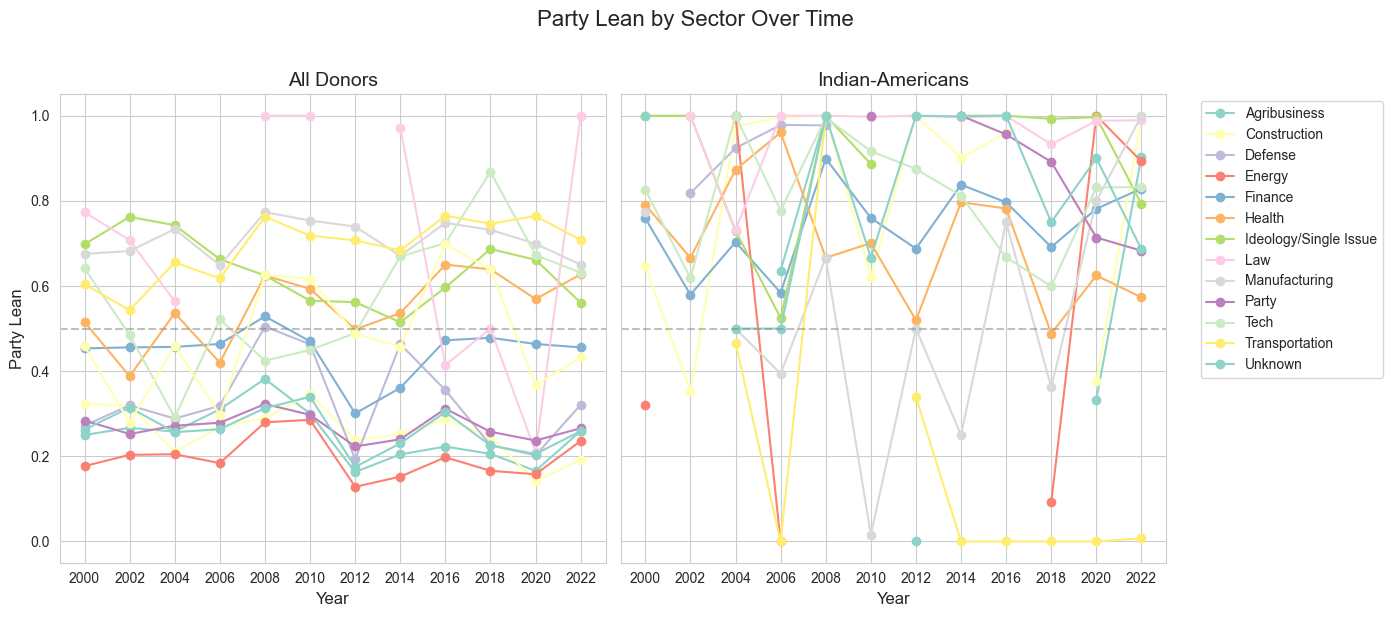

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in mean_all.columns:
    ax1.plot(
        mean_all.index,
        mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in mean_ind.columns:
    ax2.plot(
        mean_ind.index,
        mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [71]:
mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.250124,0.322902,0.272319,0.176972,0.453440,0.515514,0.698056,0.773217,0.675507,0.284039,0.641367,0.604102,0.262844,0.459073
2002,0.266826,0.319586,0.319655,0.203421,0.455819,0.387984,0.762375,0.707701,0.682170,0.252420,0.484972,0.543093,0.314438,0.278835
2004,0.258036,0.210724,0.288509,0.204900,0.456938,0.536514,0.742825,0.563805,0.733719,0.271857,0.291289,0.655318,0.256541,0.459367
2006,0.310330,0.268546,0.318630,0.183988,0.463896,0.420004,0.662795,NaN,0.648409,0.278795,0.521459,0.617948,0.263821,0.297208
2008,0.381762,0.289447,0.504839,0.279837,0.528764,0.624635,0.624789,1.000000,0.773382,0.322781,0.424680,0.762623,0.313096,0.626168
2010,0.300187,0.346791,0.462944,0.285602,0.470005,0.593347,0.565467,1.000000,0.753774,0.297500,0.449515,0.718328,0.339707,0.616618
2012,0.163193,0.238040,0.193092,0.128324,0.300571,0.498196,0.562151,NaN,0.739607,0.223092,0.489411,0.707091,0.174885,0.488156
2014,0.204474,0.251290,0.463482,0.152223,0.360694,0.536283,0.514754,0.971963,0.670968,0.239812,0.669390,0.683777,0.230380,0.457451
2016,0.222871,0.286754,0.355484,0.197707,0.472424,0.650323,0.596605,0.414287,0.748117,0.311769,0.700651,0.765003,0.303922,0.697927


In [72]:
mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,
2000,NaN,0.647091,NaN,0.320221,0.758993,0.790762,1.000000,NaN,0.772727,NaN,0.825843,NaN,1.000000
2002,NaN,0.352908,0.818182,NaN,0.579558,0.666172,1.000000,1.000000,NaN,NaN,0.619048,NaN,NaN
2004,NaN,0.974929,0.923900,1.000000,0.703108,0.872949,0.729442,0.731481,0.500000,1.000000,1.000000,0.466321,0.500000
2006,0.636364,0.996589,0.978448,0.000000,0.584300,0.960701,0.524596,1.000000,0.394231,NaN,0.777178,0.000000,0.500000
2008,1.000000,1.000000,0.977221,NaN,0.899354,0.666286,1.000000,1.000000,0.666667,NaN,0.995501,1.000000,1.000000
2010,NaN,0.621418,NaN,NaN,0.759845,0.700658,0.886439,0.997658,0.015656,1.000000,0.916667,NaN,0.666667
2012,0.000000,1.000000,NaN,NaN,0.687695,0.519652,NaN,1.000000,0.500000,NaN,0.874824,0.339209,1.000000
2014,NaN,0.901403,NaN,1.000000,0.837922,0.796900,1.000000,0.996022,0.250000,1.000000,0.811951,0.000000,0.998513
2016,NaN,0.959627,NaN,NaN,0.796605,0.781979,1.000000,0.999668,0.750000,0.956005,0.667224,0.000000,1.000000


In [73]:
dollar_mean_all = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

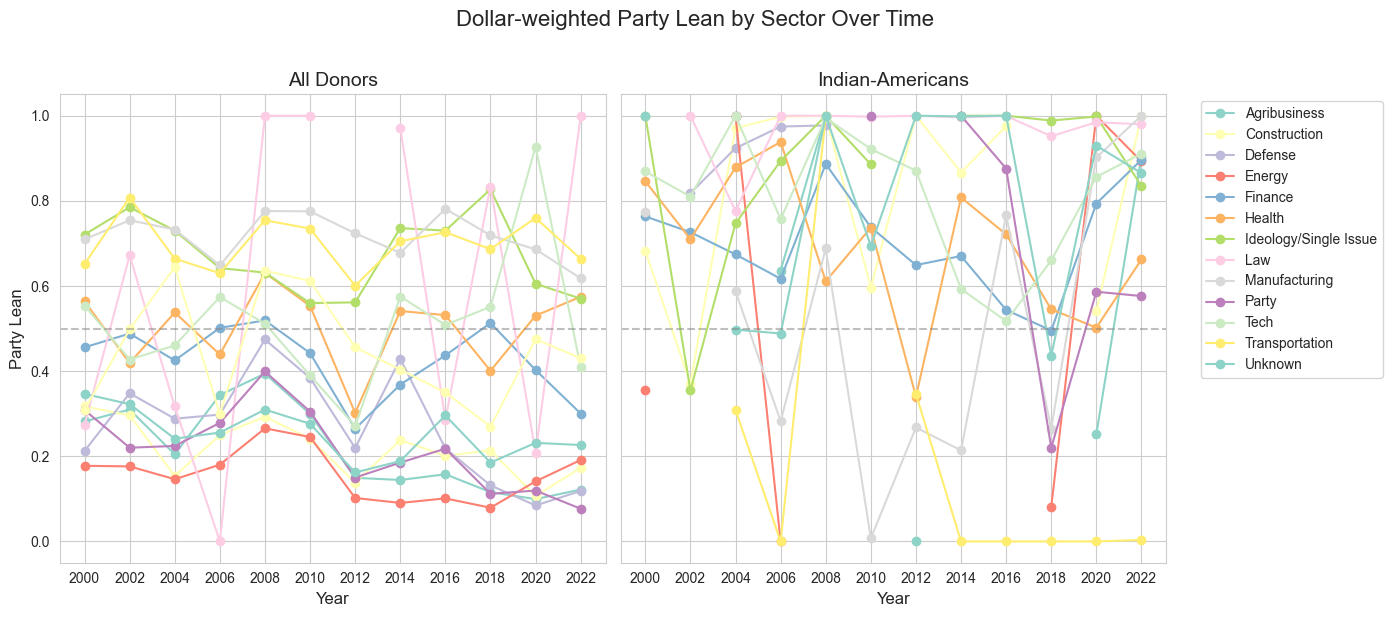

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in dollar_mean_all.columns:
    ax1.plot(
        dollar_mean_all.index,
        dollar_mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in dollar_mean_ind.columns:
    ax2.plot(
        dollar_mean_ind.index,
        dollar_mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Dollar-weighted Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [75]:
dollar_mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.281799,0.317228,0.212611,0.177688,0.455973,0.564067,0.720784,0.273908,0.709481,0.308661,0.554046,0.651339,0.346558,0.308435
2002,0.309843,0.296151,0.348016,0.176270,0.488246,0.419105,0.784956,0.671913,0.754321,0.220128,0.427330,0.807842,0.322487,0.498452
2004,0.204674,0.153690,0.288335,0.146163,0.425157,0.537809,0.729993,0.317089,0.732583,0.224355,0.460361,0.664131,0.241445,0.644097
2006,0.343967,0.249791,0.297951,0.180222,0.501724,0.439118,0.641983,0.000000,0.648242,0.278462,0.574022,0.630049,0.255749,0.299351
2008,0.394237,0.292825,0.474379,0.265627,0.519224,0.630742,0.631514,1.000000,0.776064,0.399178,0.511465,0.754543,0.309745,0.635818
2010,0.299565,0.241288,0.383928,0.245285,0.442370,0.553290,0.559889,1.000000,0.775416,0.305133,0.389931,0.734695,0.276366,0.611892
2012,0.149433,0.138343,0.219613,0.102059,0.264628,0.301752,0.561530,NaN,0.723773,0.150024,0.271471,0.600595,0.162005,0.456049
2014,0.144337,0.237916,0.428687,0.090460,0.368427,0.541284,0.735957,0.971963,0.677943,0.185211,0.575135,0.705107,0.188697,0.403649
2016,0.157789,0.201576,0.218377,0.101145,0.436966,0.531593,0.730065,0.286273,0.781234,0.217854,0.508648,0.726233,0.295923,0.349974


In [76]:
dollar_mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,
2000,NaN,0.682170,NaN,0.356316,0.763512,0.845941,1.000000,NaN,0.772727,NaN,0.868966,NaN,1.000000
2002,NaN,0.370903,0.818182,NaN,0.726368,0.710167,0.354839,1.000000,NaN,NaN,0.810127,NaN,NaN
2004,NaN,0.970820,0.923734,1.000000,0.674237,0.878540,0.746991,0.776376,0.587838,1.000000,1.000000,0.308748,0.497585
2006,0.636364,0.997489,0.974532,0.000000,0.617005,0.938322,0.893556,1.000000,0.282369,NaN,0.756968,0.000000,0.488422
2008,1.000000,1.000000,0.977221,NaN,0.886544,0.611180,1.000000,1.000000,0.688159,NaN,0.994704,1.000000,1.000000
2010,NaN,0.596430,NaN,NaN,0.738026,0.737212,0.885603,0.997694,0.007051,1.000000,0.921782,NaN,0.694059
2012,0.000000,1.000000,NaN,NaN,0.649177,0.340057,NaN,1.000000,0.267664,NaN,0.870974,0.346284,1.000000
2014,NaN,0.866598,NaN,1.000000,0.670437,0.807951,1.000000,0.996101,0.213965,1.000000,0.593084,0.000000,0.998415
2016,NaN,0.975603,NaN,NaN,0.543878,0.721222,1.000000,0.999575,0.765938,0.875749,0.517463,0.000000,1.000000


In [77]:
mean_all_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["d_ratio"].mean()
mean_ind_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle"])["d_ratio"].mean()

In [78]:
dollar_mean_all_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_ind_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle"])
    .apply(lambda x: (x["d_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

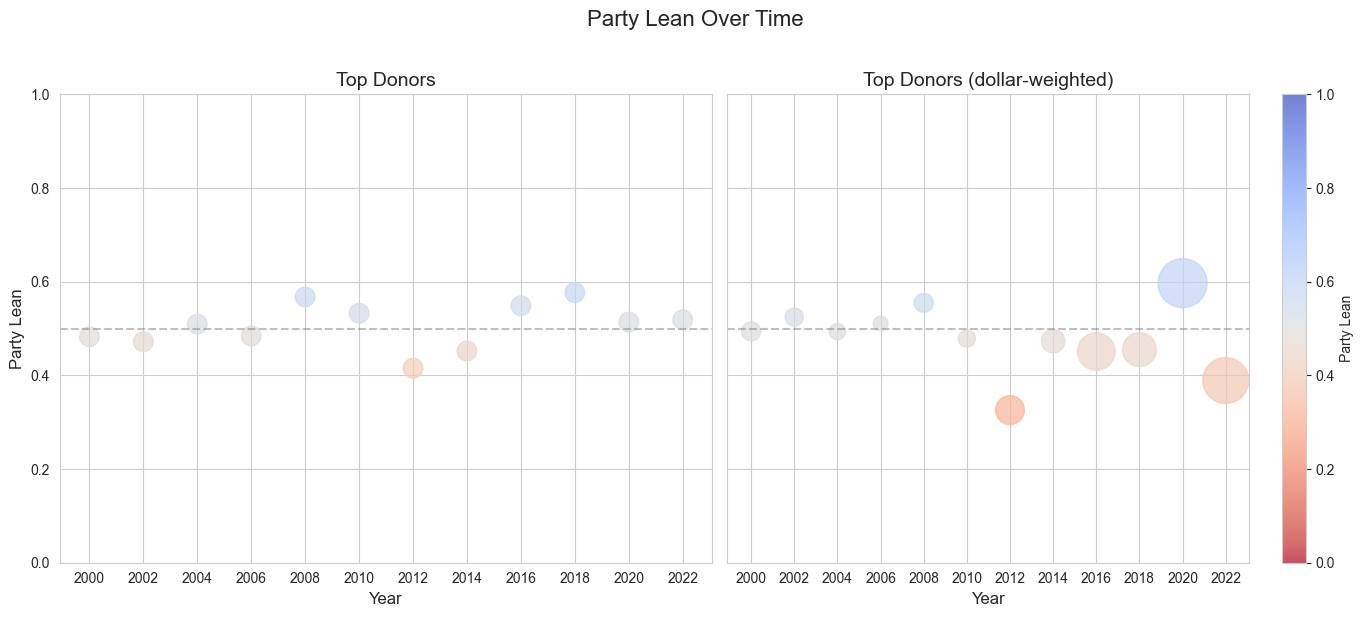

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all_by_year.index,
    mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all_by_year.index,
    dollar_mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

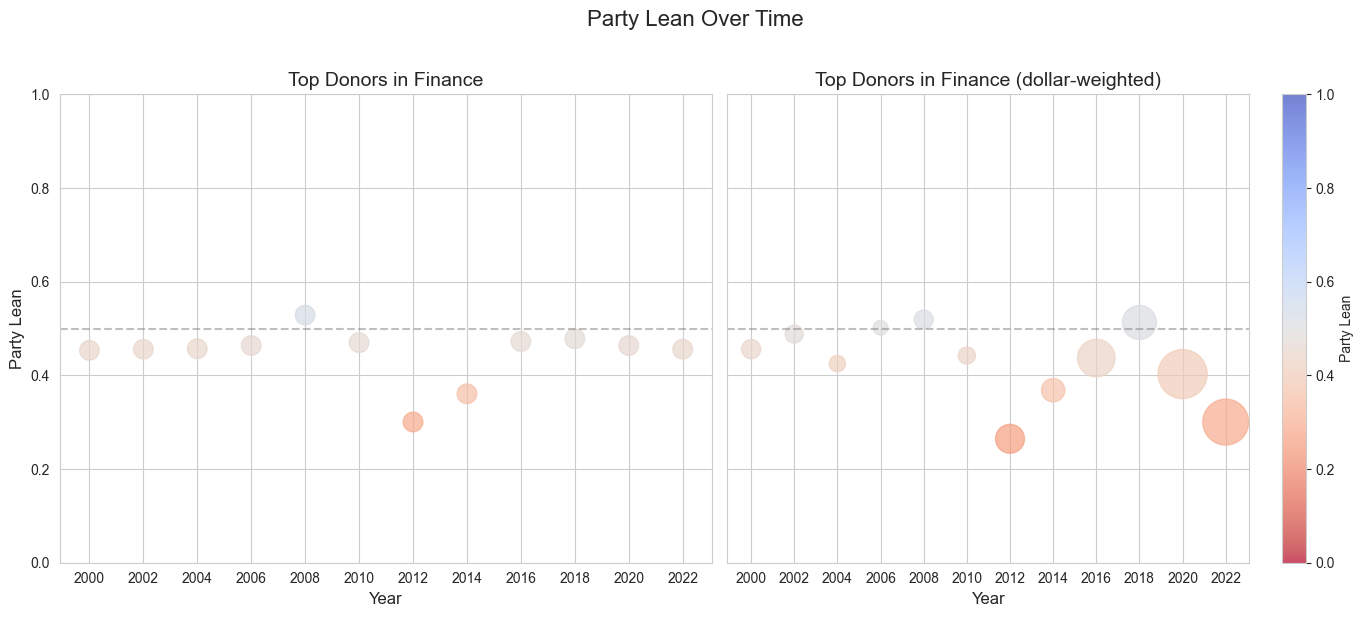

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all.index,
    mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

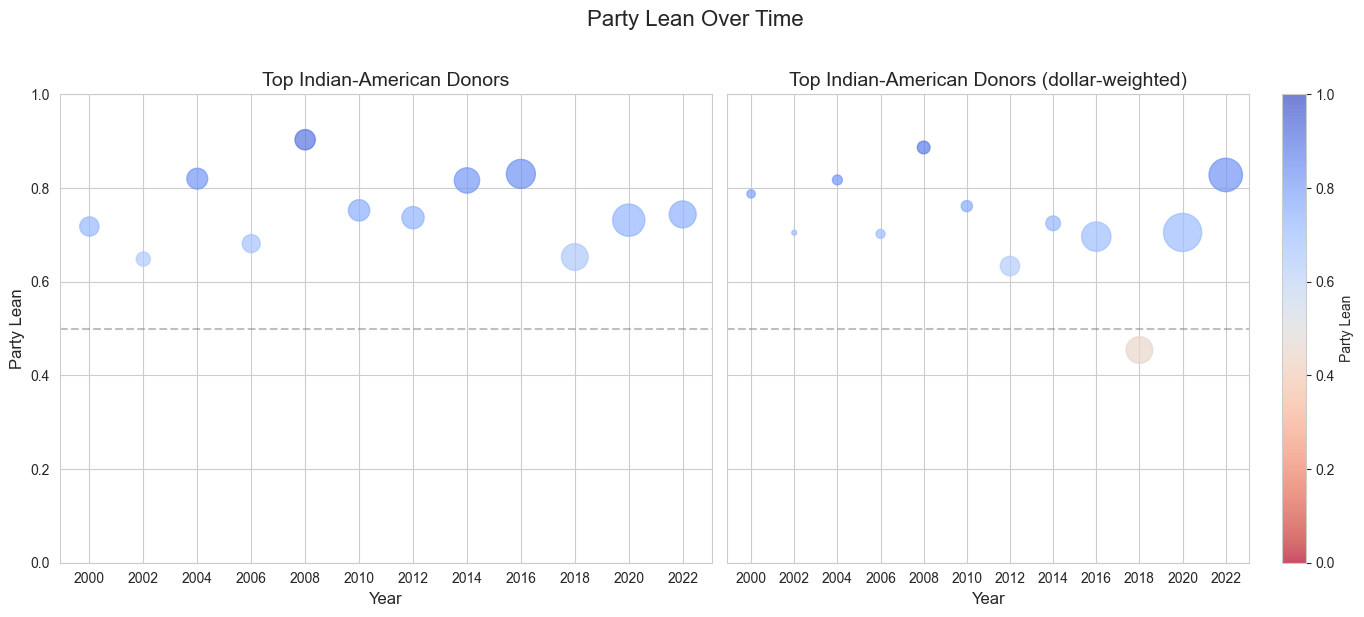

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind_by_year.index,
    mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()*4,
    c=mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind_by_year.index,
    dollar_mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/50000,
    c=dollar_mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

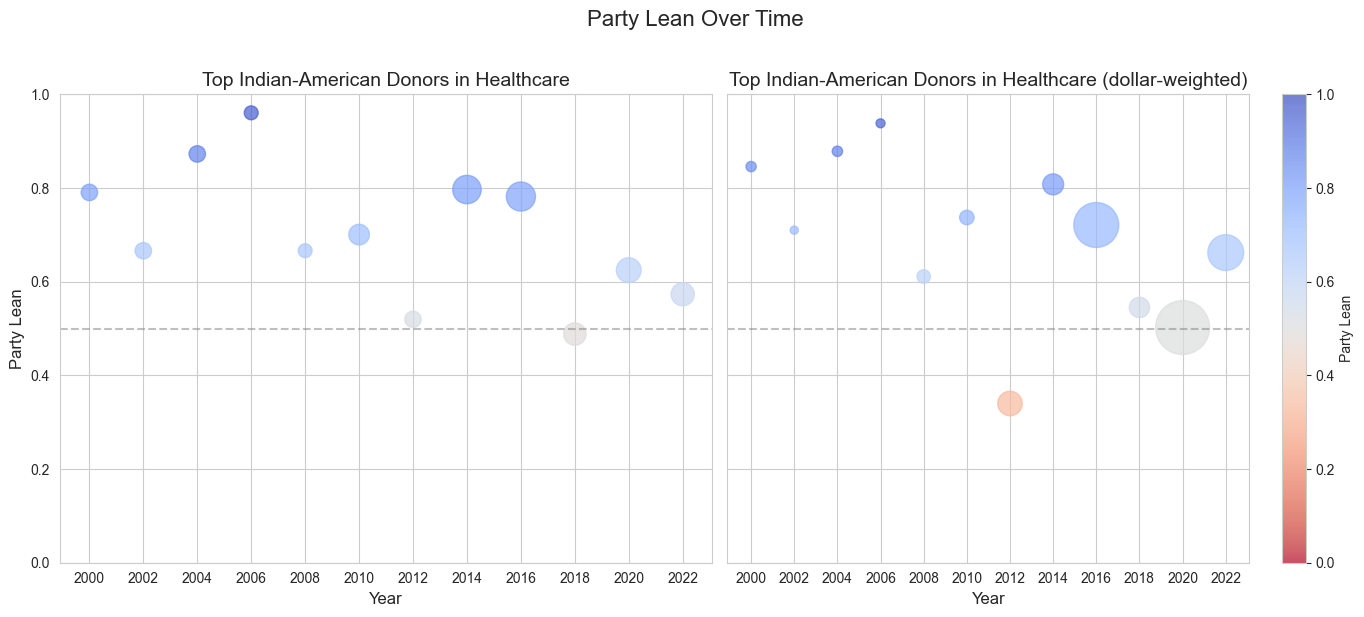

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["contrib_id"].count()*20,
    c=mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Top Indian-American Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "d_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Top Indian-American Donors in Healthcare (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [83]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].groupby(["cycle", "tag"])["total_donated"].sum()

cycle  tag               
2000   Only Democrat          158750.0
       Only Republican         20769.0
       Solidly Democrat        94850.0
2002   Leans Democrat          17500.0
       Leans Republican        21250.0
       Only Democrat           12500.0
       Only Republican         17000.0
       Solidly Democrat       103200.0
2004   Leans Democrat          29250.0
       Only Democrat           59500.0
       Solidly Democrat       189900.0
2006   Only Democrat          100500.0
       Solidly Democrat       108650.0
2008   Leans Republican        79000.0
       Only Democrat          186500.0
       Only Republican        132425.0
       Solidly Democrat        78324.0
2010   Leans Republican       139400.0
       Only Democrat          244146.0
       Only Republican         30400.0
       Solidly Democrat       105900.0
       Solidly Republican      23450.0
2012   Leans Republican       200797.0
       Only Democrat          384444.0
       Only Republican        663450.0

In [84]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["cycle"] == "2016")].sort_values(by="total_donated", ascending=False)[["cycle", "name_new", "orgname", "sector", "state", "ethnic", "tag"]]

,cycle,name_new,orgname,sector,state,ethnic,tag
90164,2016,Muneer A Satter,Satter Investment Management,Finance,IL,ind,Solidly Republican
90194,2016,Amy Joyce Rao,Integrated Archive Systems,Tech,CA,ind,Only Democrat
90259,2016,Rishi U Shah,Contextmedia,Health,IL,ind,Only Democrat
90293,2016,Shashikant Gupta,Apex Covantage,NaN,VA,ind,Only Democrat
90315,2016,Vivek Garipalli,Bayonne Medical Center,Health,NJ,ind,Third-party
...,...,...,...,...,...,...,...
99567,2016,Sonia Kapadia,Soroban Capital Partners,Finance,NY,ind,Only Democrat
99616,2016,Vinit Bodas,Deccan Value Investors,Finance,CT,ind,Only Democrat
99641,2016,Shaalu Mehra,"Gibson, Dunn & Crutcher",Law,CA,ind,Only Democrat
99777,2016,Kiran Mehta,K&L Gates,Law,NC,ind,Only Democrat


In [85]:
top_donors_per_year = (
    all_donors[all_donors["ethnic"] == "ind"].sort_values(by=["cycle", "total_donated"], ascending=[True, False])
    .groupby("cycle")
    .head(20)
)
top_donors_per_year["name_new"].value_counts()[top_donors_per_year["name_new"].value_counts() > 4]

name_new
Shekar Narasimhan    10
Vinod Khosla          8
Amy Rao               6
Prem Reddy            6
Vinod Gupta           5
Sunil Puri            5
Parag Saxena          5
Dinakar Singh         5
Niranjan S Shah       5
Name: count, dtype: int64

In [86]:
high_value_donors = all_donors[(all_donors["ethnic"] == "ind") & (all_donors["total_donated"] > 100000)]
high_value_donors["name_new"].value_counts()[high_value_donors["name_new"].value_counts() > 4]

name_new
Shekar Narasimhan    8
Vinod Khosla         6
Sunil Puri           6
Parag Saxena         6
Deven Parekh         6
Shashikant Gupta     6
Muneer A Satter      5
Name: count, dtype: int64

In [87]:
mega_donors = all_donors[(all_donors["ethnic"] == "ind")].groupby(["contrib_id", "name_new"])["total_donated"].sum().reset_index()
mega_donors[mega_donors["total_donated"] > 1000000].sort_values(by="total_donated", ascending=False)

,contrib_id,name_new,total_donated
32,U0000004761,Nishad Singh,9476000.0
9,U00000033011,Vinod Khosla,6361995.0
292,h3003465387,Shiva Dr Ayyadurai,4817653.0
11,U00000035581,Muneer A Satter,3928500.0
226,h10013502001,Prem Reddy,3122199.0
427,m0001327150,Sameer Gandhi,2357999.0
31,U0000004554,Vivek Garipalli,1905600.0
265,h30013924601,Shashikant Gupta,1895747.0
251,h3001220400,Nirmal Mulye,1732299.0
6,U00000003781,Amy Rao,1712133.0


In [88]:
all_donors[all_donors["name_new"] == "Vinod Khosla"].sort_values(by="total_donated", ascending=False)[["cycle", "name_new", "state", "total_donated"]]

,cycle,name_new,state,total_donated
149,2020,Vinod Khosla,CA,2410795.0
110197,2022,Vinod Khosla,CA,2084900.0
70097,2012,Vinod Khosla,CA,1160300.0
80679,2014,Vinod Khosla,CA,217900.0
51511,2008,Vinod Khosla,CA,122300.0
60683,2010,Vinod Khosla,CA,121900.0
7787,2020,Vinod Khosla,,100000.0
41121,2006,Vinod Khosla,CA,85100.0
97143,2016,Vinod Khosla,CA,70800.0
32625,2004,Vinod Khosla,CA,62000.0


In [92]:
all_donors[(all_donors["state"] == "FL") & (all_donors["sector"] == "Health") & (all_donors["ethnic"] == "ind")]

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,...,sector,ethnic,indian,gpt_profile,primary_party,d_ratio,r_ratio,other_ratio,tag,cycle
373,p00053429381,"MANTENA, RAMALINGA",Ramalinga Mantena,Integra Connect,NaN,H3900,F,SELF-EMPLOYED,INTEGRA CONNECT LLC,JUPITER,...,Health,ind,True,Ramalinga Mantena (born in India; resides in t...,R,0.009024,0.990976,0.000000,Solidly Republican,2020
377,U0000004388A,"MANTENA, PADMAJA",Padmaja Mantena,Integra Connect,NaN,H3900,F,HOMEMAKER,HOMEMAKER,JUPITER,...,Health,ind,True,Padmaja Mantena (born in India; resides in New...,R,0.028497,0.971503,0.000000,Solidly Republican,2020
529,h3001220400,"MULYE, NIRMAL",Nirmal Mulye,Nostrum Pharmaceuticals,NaN,H4300,M,CHAIRMAN,NOSTRUM PHARMACEUTICALS,MIAMI,...,Health,ind,True,Nirmal Mulye (born in India; resides in New Yo...,R,0.022098,0.977902,0.000000,Solidly Republican,2020
15066,f10007091761,"BANSAL, RAJENDRA",Rajendra Bansal,Physician,NaN,H1100,M,NaN,PHYSICIAN,TEQUESTA,...,Health,ind,False,NaN,D,0.756303,0.243697,0.000000,Solidly Democrat,2000
25371,d0000910214,"PATEL, KIRAN C",Kiran C Patel,Wellcare HMO,NaN,H3700,N,NaN,self/physician,TAMPA,...,Health,ind,False,NaN,D,0.608696,0.391304,0.000000,Leans Democrat,2002
37590,d0000910214,"PATEL, KIRAN",Kiran Patel,Bay Area Internal Medicine,NaN,H1130,N,PHYSICIAN,NaN,TAMPA,...,Health,ind,False,NaN,D,0.807018,0.192982,0.000000,Solidly Democrat,2004
63359,k0001503392,"TRIPATHI, POOJA",Pooja Tripathi,Nexus Clinical,NaN,H4500,U,OWNER/ENGINEER,NEXUS CLINICAL LLC,MIAMI BEACH,...,Health,ind,False,NaN,D,1.000000,0.000000,0.000000,Only Democrat,2010
64285,f0010615383,"AGRAWAL, AKHIL",Akhil Agrawal,American Medical Depot,NaN,H4100,M,PRESIDENT,AMERICAN MEDICAL DEPOT,MIAMI BEACH,...,Health,ind,False,NaN,R,0.336980,0.557987,0.105033,Leans Republican,2010
69749,h10011798371,"AGRAWAL, PIYUSH C",Piyush C Agrawal,Medical Depot Co,NaN,H1100,M,PRESIDENT,APS TECHNOLOGIES,WESTON,...,Health,ind,False,NaN,D,0.956522,0.043478,0.000000,Solidly Democrat,2010
71082,U00000043881,"MANTENA, RAMA R",Rama R Mantena,Cardinal Health,NaN,H4400,M,PHARMACIST,CARDINAL HEALTH,JUPITER,...,Health,ind,False,NaN,R,0.478080,0.521920,0.000000,Leans Republican,2012
